In [1]:
import os
import math
import numpy as np
import pandas as pd
import pandas as OneSecBin_pd

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_raw
import matplotlib.pyplot as plt_hist
import matplotlib.pyplot as plt_perievent_traces

# for resampling data
from scipy import signal

In [2]:
#. Input Deconv Data

# Target_Frame_Rate will be 20   #. This is same as the 20 frames/second for Ca Imaging  (Resample Rate )

Save_Path = '/Users/kang/Documents/GitHub/Imaging Analysis/Motion_Extraction/Put_Videos_Here/'
File_Path = '/Users/kang/Documents/GitHub/Imaging Analysis/Motion_Extraction/Put_Videos_Here/'

#File_Name = 'Ka-DS2-P5_5-S10-Sucrose_Motion.csv'   # phase III, go no go
#File_Name = 'Ka-DS1-P5_5-S35-Water_Motion.csv'   # phase III, go no go
#Motion_File_Name = '5_2022-10-18_16-24-22-Ka-DS16-P5_5-S11-Water_Aligned_Step3.csv'   

Motion_File_Name = '5_2022-10-08_13-37-08-Ka-DS12-P5_5-S6-Water_Aligned_Step3.csv'

Imaging_Onset_From_Video = 45*20    #. Only influence label for user verification , NOT important 

In [3]:
# The one second bin for the vidoe is only good for the begining confirmation of motion detection
# The previous step already aligned the overhead video to the imaging data.  Information about the variability 
# of overhead camera (variable frame rate during data collection) .  Doing this properly requires using the five second pulse
# to realign the data back to the overhead camera time .  That's not a priority at the moment.  
# use the begining time to check video, just don't use the end.  


In [4]:
df = pd.read_csv((File_Path+'/'+Motion_File_Name), low_memory=False)
print(df)

            Motion  Light_1  Light_2  Light_3  \
0       937.237132        1        1        0   
1      1821.660482        1        1        0   
2      1892.676669        1        1        0   
3      2313.887486        1        1        0   
4      2476.814197        1        1        0   
...            ...      ...      ...      ...   
47996     0.000000        1        0        0   
47997     0.003362        1        0        0   
47998     0.000000        1        0        0   
47999     0.000000        1        0        0   
48000     0.005878        1        0        0   

      original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)  \
0                                             (360, 640)                                               
1                                             (147, 234)                                               
2                                                  34398                                           

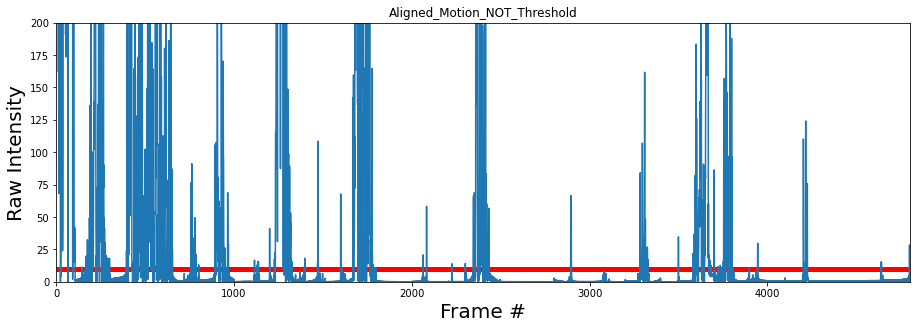

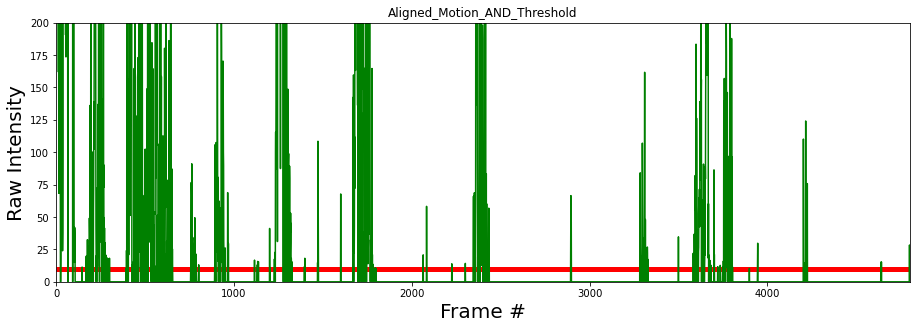

In [5]:
# Add Movement Threshold to Aligned Motion Trace (Aligned but not threshold)

Threshold_Aligned_Motion = 10   #. Any value below this value gets set to 0 


Aligned_Signal_Length = len(df['Motion'])

Final_Thresholded_Aligned_Signal_Motion = np.asarray( [0]*Aligned_Signal_Length)
Final_Thresholded_Aligned_Signal_Motion = [i if i> Threshold_Aligned_Motion else 0 for i in df['Motion']] 

df['Motion_Thresholded'] = Final_Thresholded_Aligned_Signal_Motion

#. Add Binary Thresholded Motion data
Final_Thresholded_Aligned_Signal_Motion_Binary = np.asarray( [0]*Aligned_Signal_Length)
Final_Thresholded_Aligned_Signal_Motion_Binary = [1 if i> 0 else 0 for i in df['Motion_Thresholded']] 
df['Motion_Thresholded_Binary'] = Final_Thresholded_Aligned_Signal_Motion_Binary


# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Motion, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
plt_raw.plot(df['Motion'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Motion_NOT_Threshold', fontdict=None, loc='center')
plt_raw.xlim(0, len(df['Motion'])/10)
plt_raw.ylim(0, 200)
plt_raw.show()





# Plot Motion (Aligned and Thresholded)

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Motion, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
plt_raw.plot(df['Motion_Thresholded'], 'green')


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Motion_AND_Threshold', fontdict=None, loc='center')
plt_raw.xlim(0, len(df['Motion'])/10)
plt_raw.ylim(0, 200)
plt_raw.show()

In [6]:
df['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][11]= Threshold_Aligned_Motion
df['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][12]= Imaging_Onset_From_Video

/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_23608/3897227417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][11]= Threshold_Aligned_Motion
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_23608/3897227417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][12]= Imaging_Onset_From_Video


In [7]:
signal_Length = len(df)
#x_axis = np.arange(0,signal_Length) 
Signal_Light_1 = np.asarray( [0]*signal_Length)
Signal_Light_1 = [1 if i> 0 else 0 for i in df['Light_1']] 

Signal_Light_2 = np.asarray( [0]*signal_Length)
Signal_Light_2 = [1 if i> 0 else 0 for i in df['Light_2']] 


# Find Imaging Onset Time in frames using Signal_Light_1
# res = list(filter(lambda i: i > 0.5, Signal_Light_1))[0]
# Image_Onset =  Signal_Light_1.index(res)
Image_Onset = 0 # Image onset starts at bin zero bc only the imaging time were cropped out from previous steps 

# Find Imaging Offset Time in frames using Signal_Light_1
# by fliping Signal_Light front and end, and look for last time when signal was still on.  
Flipped_Signal_Light_1 = list(reversed(Signal_Light_1))
res = list(filter(lambda i: i > 0.5, Flipped_Signal_Light_1))[0]
#Image_Offset =  len(Signal_Light_1)- Flipped_Signal_Light_1.index(res)
Image_Offset =  len(Signal_Light_1)-1  # the previous steps removed the end , so the end is the end of imaging

#  Duration in frames

Image_Duration = Image_Offset - Image_Onset +1

# Find 5 seconds on/off Time in frames using Signal_Light_2

counter = 0
Five_Second_On_Off_Trace = np.asarray( [0]*len(df))
Five_Second_On_Off_Count = 0
Five_Second_On_Off = defaultdict(list)
Five_Second_On_Off['Duration'].append(None)
Five_Second_On_Off['Time_Stamp'].append(None)

for i in range(len(df)-1):
    if(Signal_Light_2[i] == Signal_Light_2[i+1]):
        counter = counter +1
    elif(Signal_Light_2[i] != Signal_Light_2[i+1]):
        Five_Second_On_Off['Duration'].append(counter+1)
        Five_Second_On_Off['Time_Stamp'].append(i+1)
        Five_Second_On_Off_Count = Five_Second_On_Off_Count+1
        counter = 0                                       # reset counter
        
        
#  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
del Five_Second_On_Off['Duration'][0]
del Five_Second_On_Off['Time_Stamp'][0]

# print(Five_Second_On_Off_Count)
# print(Five_Second_On_Off)

for i in range(Five_Second_On_Off_Count):
    tempa = Five_Second_On_Off['Time_Stamp'][i]
    #tempa = int(tempa[0])   # Convert to Integer
    Five_Second_On_Off_Trace[tempa:tempa+1] = [1]

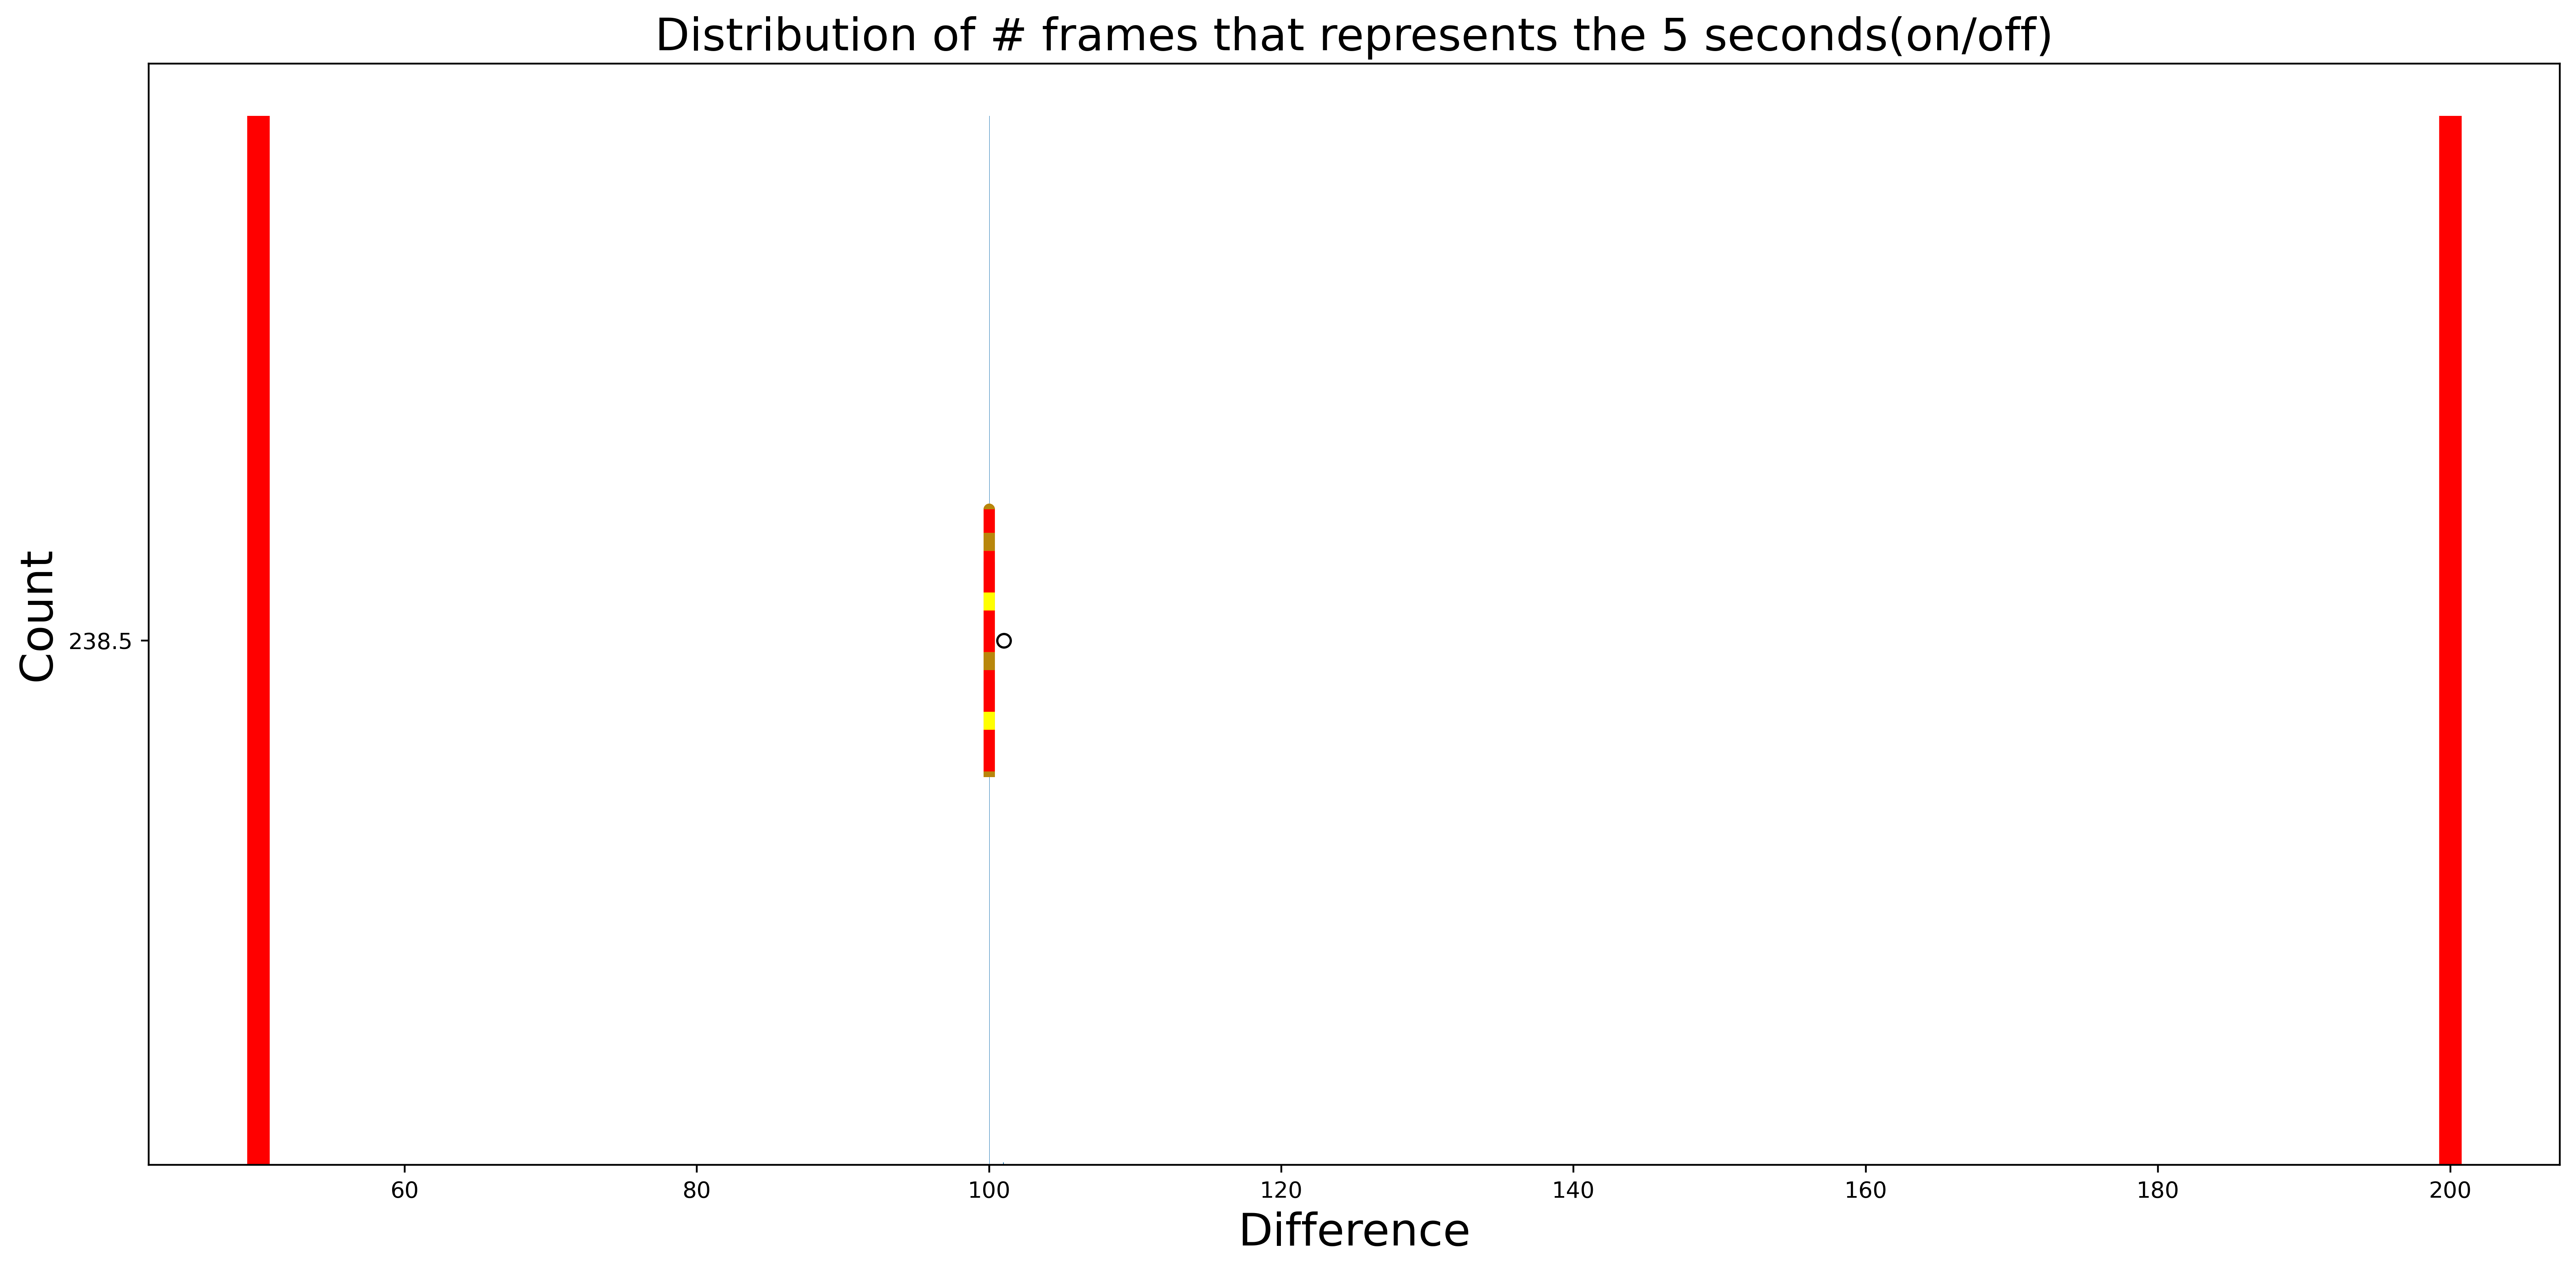

Image Duration in Frames (after accounting for Begin and End Time):    48001
Median Duration of 5s pulse in Frames:    100.0
Maximum 101
Minimum 100
Estimated Frame Rate:    20.0
Estimated number of 5s pulse:    480.01
Actual number of 5s pulse:    479


In [8]:
#print(Five_Second_On_Off)

# Find averaged duration of 5s on/off

############################
##.  Histogram
#####################
fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(2,1 ,1)


n_bins = 20


#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
dist = Five_Second_On_Off['Duration'][1:Five_Second_On_Off_Count]   #. Omit first value (which is Ca Imaging start)
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('Distribution of # frames that represents the 5 seconds(on/off)'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')




Position_one_label = 'Veh-Baseline'

# Box plot Settings
boxprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=5, color='Yellow')
meanpointprops = dict(marker='D', markeredgecolor='red',markerfacecolor='red')
meanlineprops = dict(linestyle='--', linewidth=5, color='red')
whiskerprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
capprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')

plt_perievent_traces.boxplot(dist, showmeans=True, meanline = True, positions=[max(n)/2], widths = max(n)/4, boxprops=boxprops,  meanprops=meanlineprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, vert=False) #red is mean,  green is median
plt_perievent_traces.show()





Five_Second_On_Off_Median_Dur = np.median(dist)
Estimated_Count = Image_Duration/Five_Second_On_Off_Median_Dur
Estimated_Avg_FrameRate = Five_Second_On_Off_Median_Dur/5

print('Image Duration in Frames (after accounting for Begin and End Time):   ', Image_Duration)
print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
print('Maximum', max(dist))
print('Minimum', min(dist))

print('Estimated Frame Rate:   ', Estimated_Avg_FrameRate)
print('Estimated number of 5s pulse:   ', Estimated_Count)
print('Actual number of 5s pulse:   ', Five_Second_On_Off_Count)

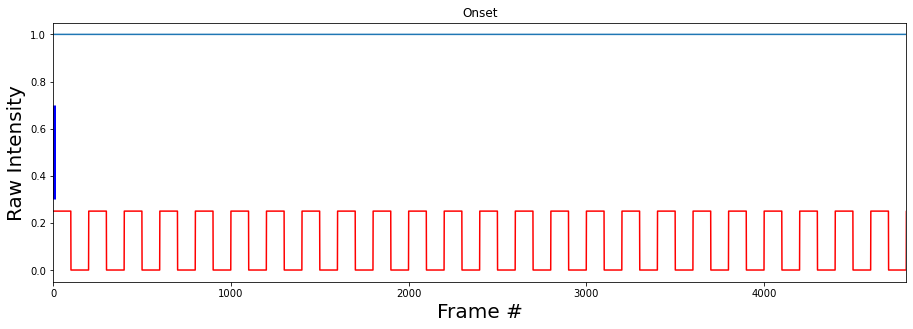

Image Onset in Frames =  0


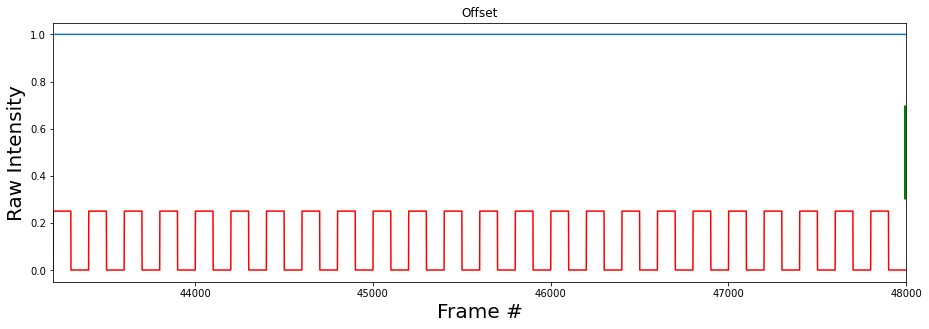

Image Offset in Frames =  48000


In [9]:
# Plot Light_1  for Session Begin

# Draw Image_Onset Line
plt_raw.vlines(x= Image_Onset, ymin=0.3, ymax=0.7, colors='blue', lw=5, label='vline_single - partial height')

temp_signal_min =np.mean(df['Light_1'])  
plt_raw.plot(df['Light_1'])
Light_1_display = [x *temp_signal_min*0.5 for x in df['Light_1']]

temp_signal_min =np.mean(df['Light_2']) 
Light_2_display = [x *temp_signal_min*0.5 for x in df['Light_2']]
plt_raw.plot(Light_2_display, 'red')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

# temp_signal_min =np.mean(df['Light_1'])                 
# display = [x *temp_signal_min*0.5 for x in df['Light_1']]
# plt_raw.plot(display)
# plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Onset', fontdict=None, loc='center')
plt_raw.xlim(0, len(df)/10)
plt_raw.show()
print('Image Onset in Frames = ', str(Image_Onset))

# Draw Image_Offset Line
plt_raw.vlines(x= Image_Offset, ymin=0.3, ymax=0.7, colors='green', lw=5, label='vline_single - partial height')

plt_raw.plot(df['Light_1'])
Light_1_display = [x *temp_signal_min*0.5 for x in df['Light_1']]

Light_2_display = [x *temp_signal_min*0.5 for x in df['Light_2']]
plt_raw.plot(Light_2_display, 'red')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)


plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Offset', fontdict=None, loc='center')
plt_raw.xlim(len(df)/10*9,len(df) )

plt_raw.show()
print('Image Offset in Frames = ', str(Image_Offset))

 


In [10]:
#. Correct for manual shifting from previous steps .  THis only influence bin label for timesmtaps for human verification
# unit in seconds
#. +1 for correcting for binning 

Correction_Bin_TimeStamp_Label= np.floor((Imaging_Onset_From_Video-Image_Onset)/Estimated_Avg_FrameRate)+1
print(Correction_Bin_TimeStamp_Label)

46.0


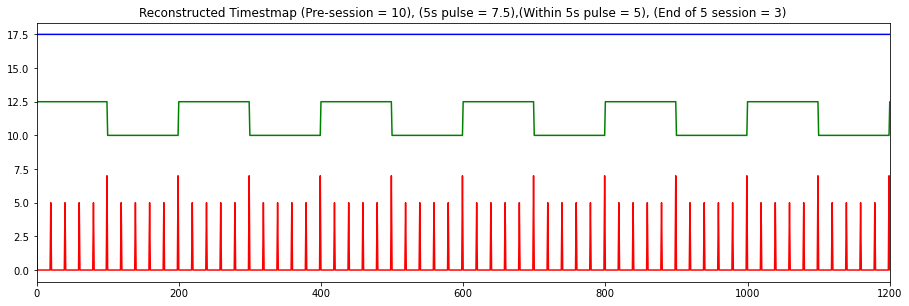

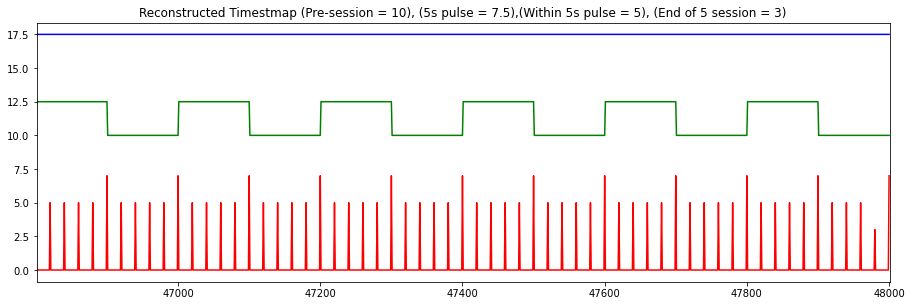

In [11]:
#.  Marks location for binning frames to get binned seconds data

EverySecond = np.asarray( [0]*signal_Length)
Avg_FrameRate = math.ceil(Estimated_Avg_FrameRate)  #it's really median frame rate 
counter_one = 0
counter_two = 0
counter_three = 0
last_detected_timestamp = 0

for i in range(0,signal_Length):
    
#     #. Pre 5 seconds pulse period  (1 to Image_Onset)
#     if(0<=i<Image_Onset):
#         counter_one = counter_one +1
#         if(counter_one == Avg_FrameRate):
#             counter_one = 0
#             EverySecond[i]=10   
     
        #. Pre 5 seconds pulse period  (1 to Image_Onset)
    if(0<=i<Image_Onset):
        counter_one = counter_one +1
        if(counter_one == Avg_FrameRate):
            counter_one = 0
            EverySecond[i]=10   
    
    
    
    if((Image_Onset == 0) & (i == 0)):
        EverySecond[i]=7.5
        EverySecond[i+Avg_FrameRate*1]= 5
        EverySecond[i+Avg_FrameRate*2]= 5
        EverySecond[i+Avg_FrameRate*3]= 5                  
        EverySecond[i+Avg_FrameRate*4]= 5 
#         #last_detected_timestamp = i+Avg_FrameRate*4  #.  this is for the next step

            
            
#. During 5 seconds pulse period (Image_Onset to Image_Offset)
    if(Image_Onset<=i<Image_Offset):
        if ((df['Light_2'][i] != df['Light_2'][i+1])):

            EverySecond[i]=7.5
            EverySecond[i+Avg_FrameRate*1]= 5
            EverySecond[i+Avg_FrameRate*2]= 5
            EverySecond[i+Avg_FrameRate*3]= 5                  
            EverySecond[i+Avg_FrameRate*4]= 5 
            last_detected_timestamp = i+Avg_FrameRate*4  #.  this is for the next step


# #.  Post 5 seconds pulse period (Image_Offset to signal_Length)
num_of_run = math.floor((signal_Length-last_detected_timestamp)/Avg_FrameRate)
for i in range(num_of_run):
    EverySecond[last_detected_timestamp+Avg_FrameRate*i]= 3
    
# add the last pulse at the end of the session (data was previously cut to only include imaing time window)
EverySecond[signal_Length-1]=7.5


                
# #.  Post 5 seconds pulse period (Image_Offset to signal_Length)
#     if(Image_Offset<=i<signal_Length):
#         counter_three = counter_three +1
#         if(counter_three == Avg_FrameRate):
#             counter_three = 0
#             EverySecond[i]=20


plt_raw.plot(EverySecond, 'red')

Light_1_display = [x *temp_signal_min*5+15 for x in df['Light_1']]
plt_raw.plot(Light_1_display, 'blue')

Light_2_display = [x *temp_signal_min*5+10 for x in df['Light_2']]
plt_raw.plot(Light_2_display, 'green')

plt_raw.title('Reconstructed Timestmap (Pre-session = 10), (5s pulse = 7.5),(Within 5s pulse = 5), (End of 5 session = 3)')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.xlim(0, len(df)/40)   #. Begining
#plt_raw.xlim(len(df)/10*9.75,len(df) )  # Ending
plt_raw.show()




plt_raw.plot(EverySecond, 'red')

Light_1_display = [x *temp_signal_min*5+15 for x in df['Light_1']]
plt_raw.plot(Light_1_display, 'blue')

Light_2_display = [x *temp_signal_min*5+10 for x in df['Light_2']]
plt_raw.plot(Light_2_display, 'green')


plt_raw.title('Reconstructed Timestmap (Pre-session = 10), (5s pulse = 7.5),(Within 5s pulse = 5), (End of 5 session = 3)')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
#plt_raw.xlim(0, len(df)/40)   #. Begining
plt_raw.xlim(len(df)/10*9.75,len(df) )  # Ending
plt_raw.show()





In [12]:
# Convert "EverySecond" into timestamps in frames
Reconstructed_Second = defaultdict(list)
Reconstructed_Second['Frame'].append(None)

for i in range(len(df)-1):
    
    if(EverySecond[i] >0):
        Reconstructed_Second['Frame'].append(i)                                # reset counter
        
#  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
del Reconstructed_Second['Frame'][0]



#. Bins data by summing across frames 
OneSecBinnedMotion = defaultdict(list)
OneSecBinnedMotion['Label'].append(None)
OneSecBinnedMotion['TimeLabel'].append(None)
OneSecBinnedMotion['Motion_Binary'].append(None)
OneSecBinnedMotion['Motion_Amp'].append(None)
OneSecBinnedMotion['Light_1'].append(None)
OneSecBinnedMotion['Light_2'].append(None)
OneSecBinnedMotion['Light_3'].append(None)
OneSecBinnedMotion['Light_3_Binary'].append(None)

for i in range(len(Reconstructed_Second['Frame'])-1):
    OneSecBinnedMotion['Label'].append(i)
    
    TimeDuration = i+Correction_Bin_TimeStamp_Label   #. This accounts for the manual alignment done in the begingin of the session from previous step.  
    TimeinHours = np.floor(TimeDuration /3600)
    TimeinMinutes = np.floor((TimeDuration- TimeinHours*3600)/60)
    TimeinSeconds = np.floor((TimeDuration - TimeinHours*3600 - TimeinMinutes*60))
    TimeLabel = ( str(int(TimeinHours)) + ':' + str(int(TimeinMinutes)) + ':' + str(int(TimeinSeconds)) )
    OneSecBinnedMotion['TimeLabel'].append(TimeLabel)
    
    
    TempSum = np.sum(df['Motion_Thresholded'][Reconstructed_Second['Frame'][i]:Reconstructed_Second['Frame'][i+1]])      #.  Change this ***********
    OneSecBinnedMotion['Motion_Amp'].append(TempSum)    
    # convert to binary (1 = movement, 2 =no movement)
    if(TempSum > 0):
        OneSecBinnedMotion['Motion_Binary'].append(1)
    else:
        OneSecBinnedMotion['Motion_Binary'].append(0)
    
    TempSum = np.sum(df['Light_1'][Reconstructed_Second['Frame'][i]:Reconstructed_Second['Frame'][i+1]])      #.  Change this ***********
    OneSecBinnedMotion['Light_1'].append(TempSum)
    
    TempSum = np.sum(df['Light_2'][Reconstructed_Second['Frame'][i]:Reconstructed_Second['Frame'][i+1]])      #.  Change this ***********
    OneSecBinnedMotion['Light_2'].append(TempSum)
    
    TempSum = np.sum(df['Light_3'][Reconstructed_Second['Frame'][i]:Reconstructed_Second['Frame'][i+1]])      #.  Change this ***********
    OneSecBinnedMotion['Light_3'].append(TempSum)
    # convert to binary (1 = movement, 0 =no movement)
    if(TempSum > 0):
        OneSecBinnedMotion['Light_3_Binary'].append(1)
    else:
        OneSecBinnedMotion['Light_3_Binary'].append(0)
    
#  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
del OneSecBinnedMotion['Label'][0]
del OneSecBinnedMotion['TimeLabel'][0]
del OneSecBinnedMotion['Motion_Binary'][0]
del OneSecBinnedMotion['Motion_Amp'][0]
del OneSecBinnedMotion['Light_1'][0]
del OneSecBinnedMotion['Light_2'][0]
del OneSecBinnedMotion['Light_3'][0]

#print(OneSecBinnedMotion)

# # Convert dictionary to pandas data frame 

# Creating the DataFrame
OneSecBin_pd = pd.DataFrame({'Label':OneSecBinnedMotion['Label'],
                   'TimeLabel':OneSecBinnedMotion['TimeLabel'],
                   'Motion_Binary':OneSecBinnedMotion['Motion_Binary'],
                   'Motion_Amp':OneSecBinnedMotion['Motion_Amp'],
                   'Light_1':OneSecBinnedMotion['Light_1'],
                   'Light_2': OneSecBinnedMotion['Light_2'],
                   'Light_3': OneSecBinnedMotion['Light_3']})

# OneSecBin_pd = OneSecBin_pd.DataFrame({'Label':OneSecBinnedMotion['Label'],
#                    'TimeLabel':OneSecBinnedMotion['TimeLabel'],
#                    'Motion_Binary':OneSecBinnedMotion['Motion_Binary'],
#                    'Motion_Amp':OneSecBinnedMotion['Motion_Amp'],
#                    'Light_1':OneSecBinnedMotion['Light_1'],
#                    'Light_2': OneSecBinnedMotion['Light_2'],
#                    'Light_3': OneSecBinnedMotion['Light_3']})
print(OneSecBin_pd)


      Label TimeLabel  Motion_Binary    Motion_Amp  Light_1  Light_2  Light_3
0         0    0:0:46              1  16253.972082       20       20        0
1         1    0:0:47              1   5911.303206       20       20        0
2         2    0:0:48              1  18282.574332       20       20        0
3         3    0:0:49              1  17319.618604       20       20        4
4         4    0:0:50              1  16573.983768       19       19        3
...     ...       ...            ...           ...      ...      ...      ...
2394   2394   0:40:40              0      0.000000       20       20        0
2395   2395   0:40:41              0      0.000000       20        1        0
2396   2396   0:40:42              0      0.000000       20        0        0
2397   2397   0:40:43              0      0.000000       20        0        0
2398   2398   0:40:44              0      0.000000       20        0        0

[2399 rows x 7 columns]


[20, 20, 20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

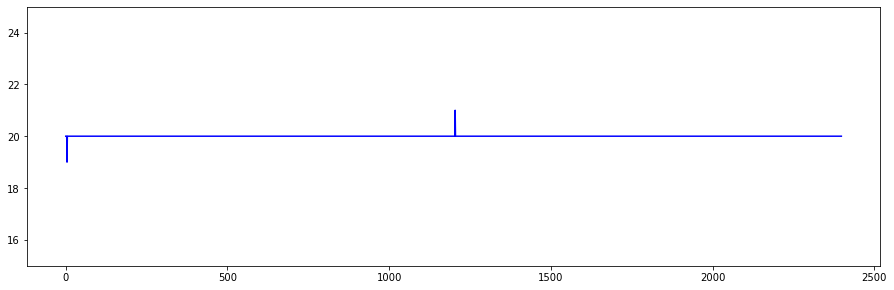

In [13]:
Interval_Duration = []
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
for i in range(len(Reconstructed_Second['Frame'])-1):
    Current = Reconstructed_Second['Frame'][i]
    Next= Reconstructed_Second['Frame'][i+1]
    Interval_Duration.append(Next-Current)
plt_raw.plot(Interval_Duration, 'blue')    
plt_raw.ylim(15, 25)

print(Interval_Duration)

/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_23608/3673702477.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  BinnedMotion_display = [1+x *temp_signal_min/(500*np.median(OneSecBinnedMotion['Motion_Amp'])) for x in OneSecBinnedMotion['Motion_Amp']]
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_23608/3673702477.py:18: RuntimeWarning: invalid value encountered in double_scalars
  BinnedMotion_display = [1+x *temp_signal_min/(500*np.median(OneSecBinnedMotion['Motion_Amp'])) for x in OneSecBinnedMotion['Motion_Amp']]


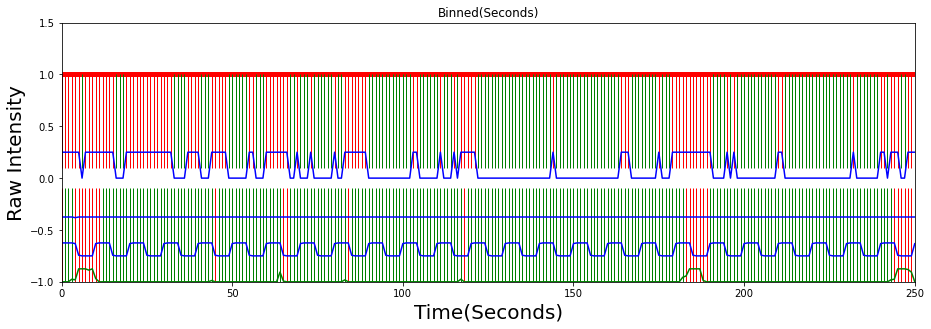

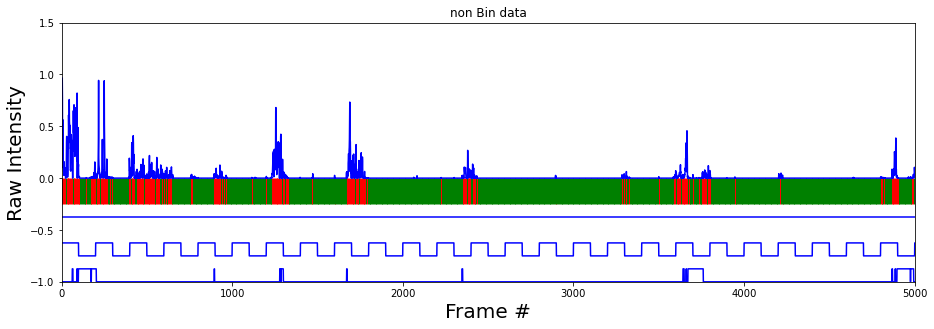

In [14]:
# Plotting Binned Data 
# Draw Threshold Line
plt_raw.hlines(y= 1, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')

BinnedMotion_display = [-0.5+x *temp_signal_min/80 for x in OneSecBinnedMotion['Light_1']]
plt_raw.plot(BinnedMotion_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

BinnedMotion_display = [-0.75+x *temp_signal_min/80 for x in OneSecBinnedMotion['Light_2']]
plt_raw.plot(BinnedMotion_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

BinnedMotion_display = [-1+x *temp_signal_min/80 for x in OneSecBinnedMotion['Light_3']]
plt_raw.plot(BinnedMotion_display, 'green')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)


BinnedMotion_display = [1+x *temp_signal_min/(500*np.median(OneSecBinnedMotion['Motion_Amp'])) for x in OneSecBinnedMotion['Motion_Amp']]
plt_raw.plot(BinnedMotion_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

BinnedMotion_display = [x *temp_signal_min*0.5 for x in OneSecBinnedMotion['Motion_Binary']]
plt_raw.plot(BinnedMotion_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

for i in range(len(OneSecBinnedMotion['Motion_Binary'])):
    if(OneSecBinnedMotion['Motion_Binary'][i]==0):
        plt_raw.vlines(x= i, ymin=0.1, ymax=1, colors='green', lw=1, label='vline_single - partial height')
    else:
        plt_raw.vlines(x= i, ymin=0.1, ymax=1, colors='red', lw=1, label='vline_single - partial height')

for i in range(len(OneSecBinnedMotion['Light_3_Binary'])):
    if(OneSecBinnedMotion['Light_3_Binary'][i]==0):
        plt_raw.vlines(x= i, ymin=-1, ymax=-0.1, colors='green', lw=1, label='vline_single - partial height')
    else:
        plt_raw.vlines(x= i, ymin=-1, ymax=-0.1, colors='red', lw=1, label='vline_single - partial height')


plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Time(Seconds)', size = 20)
plt_raw.title('Binned(Seconds)', fontdict=None, loc='center')
plt_raw.xlim(0, len(OneSecBinnedMotion['Motion_Amp']))
#plt_raw.xlim(1500, 2000)
plt_raw.xlim(0, 250)
plt_raw.ylim(-1, 1.5)
plt_raw.show()






# Plotting Unbinned Data
# Plot Light_1  for Session Begin




plt_raw.plot(df['Motion_Thresholded']/(120*np.nanmean(df['Motion_Thresholded']))+0 , color ='b') 

Light_1_display = [-0.5+ x *temp_signal_min*0.25 for x in df['Light_1']]
plt_raw.plot(Light_1_display,'blue')

 
Light_2_display = [-0.75+ x *temp_signal_min*0.25 for x in df['Light_2']]
plt_raw.plot(Light_2_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)


Light_2_display = [-1+ x *temp_signal_min*0.25 for x in df['Light_3']]
plt_raw.plot(Light_2_display, 'blue')
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

n= 5  #. it will draw every 10th line (so it runs faster)
for i in range(len(df['Motion_Thresholded'])):
    if i % n == 0:
        if(df['Motion_Thresholded_Binary'][i]== 1):
            plt_raw.vlines(x= i, ymin=-0.25, ymax=0, colors='red', lw=1, label='vline_single - partial height')
        else:
            plt_raw.vlines(x= i, ymin=-0.25, ymax=0, colors='green', lw=1, label='vline_single - partial height')


# temp_signal_min =np.mean(df['Light_1'])                 
# display = [x *temp_signal_min*0.5 for x in df['Light_1']]
# plt_raw.plot(display)
# plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('non Bin data', fontdict=None, loc='center')
#plt_raw.xlim(0, 250*20)
plt_raw.xlim(0, 250*20)
#plt_raw.xlim(0, 500)
plt_raw.ylim(-1, 1.5)
plt_raw.show()



# No motion detected prior to imaging onset is normal because previous steps resampled data within the 5s on/off timestmaps
#. No resampling was done outside the 5s on/ff events, so there's no motion data prior to imaging or after imaging.  


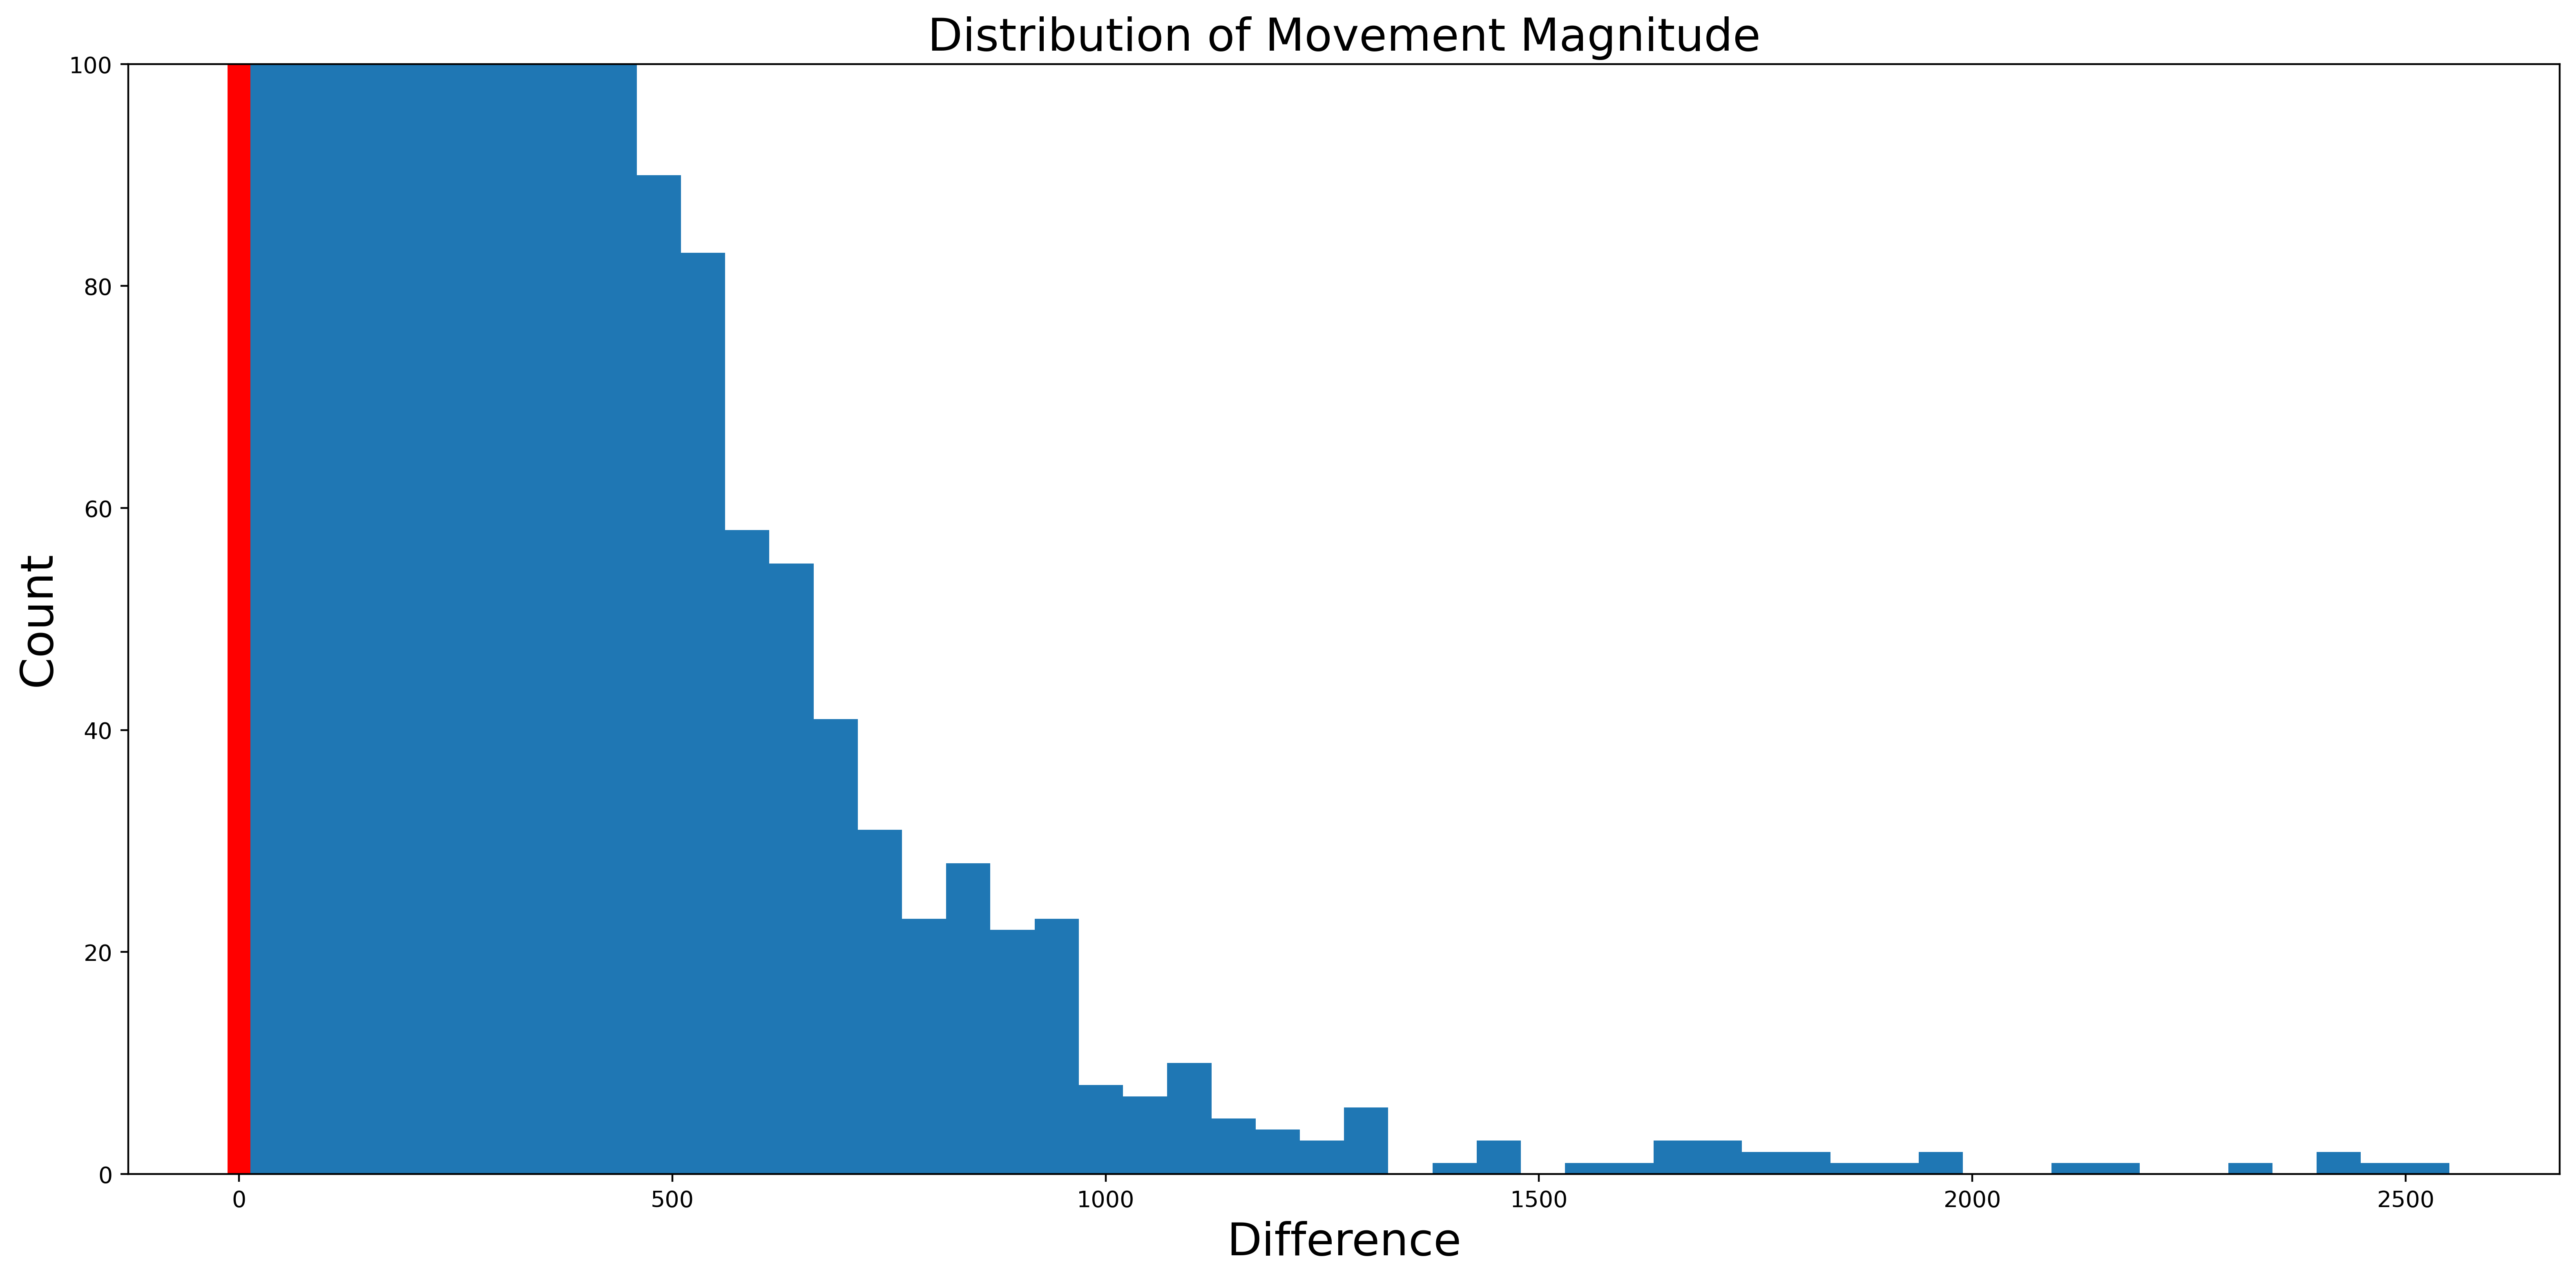

In [15]:
############################
##.  Histogram
#####################
fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(2,1 ,1)


n_bins = 50


#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
#dist = OneSecBinnedMotion['Motion_Amp']  # 1s BINNED motion data 
dist = df['Motion_Thresholded']    #. NON bin Motion

# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('Distribution of Movement Magnitude'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
plt_hist.ylim(0,100)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')




In [16]:
# #. print df for imaging analysis
# #print(df)

# ##Ka Added for exporting trace to excel
# ###################################
# ##Export data as CSV file
# ##for TimeStampExport to csv

savefilename = os.path.join(Save_Path, (Motion_File_Name.split('_Aligned_Step3')[0]  + '_Completed_For_Imaging_Align_w_Whole_Step4'+'.csv'))

df.to_csv(savefilename, mode='w', index=False, header=True)
        
print('Data Exported')

Data Exported


In [17]:
####### print OneSecBinnedMotion for human verification 

#Ka Added for exporting trace to excel
##################################
#Export data as CSV file
#for TimeStampExport to csv

savefilename = os.path.join(Save_Path, (Motion_File_Name.split('_Aligned_Step3')[0]  + '_Binned_1_Sec_Align_w_Whole_Step4'+'.csv'))

OneSecBin_pd.to_csv(savefilename, mode='w', index=False, header=True)
        
print('Data Exported')

Data Exported


In [18]:
print(Correction_Bin_TimeStamp_Label)

46.0


In [19]:
Image_Onset = 299

Imaging_Onset_From_Video = 502  

In [20]:
print(Image_Onset)

299
